# Welcome to the Team Communication Toolkit Demo Notebook!

Written by [Xinlan Emily Hu](https://xinlanemilyhu.com), and last updated on **October 7, 2024**.

This notebook will walk through how to install the [Team Communication Toolkit](https://pypi.org/project/team-comm-tools/) and use it to analyze conversational data. The goal of the Team Communication Toolkit is to make it easy to bootstrap analyses of multi-party text communication; you can read a little bit more about our tool [here](https://conversational-featurizer.readthedocs.io/en/latest/intro.html).

## Step 0.0: Install the Toolkit Via Pip

The first thing you need to do is to install the toolkit via Pip. You can find a list of our requirements [here](https://github.com/Watts-Lab/team_comm_tools/blob/main/requirements.txt).

A few specific notes:
- We require **Python >= 3.10**.
- We also require **numpy<2.0.0**; the upgrade to numpy 2 created breaking changes that affected many Python packages, include several that we depend on. If you have the latest numpy, you will get an error like the following: `ValueError: numpy.dtype size changed, may indicate binary incompatibility.`
- For Windows users specifically, you should download the latest version of Torch (2.4.1), as there is a known dependency issue on Windows machines.

In [1]:
# Uncomment and run this line of code if you need to install the package
# !pip install team_comm_tools

Here, we confirm that we have successfully installed the package!

In [2]:
!pip list | grep team_comm_tools

team_comm_tools               0.1.4


Now let's import the package along with other packages we will need to run the demo.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from team_comm_tools import FeatureBuilder

[nltk_data] Downloading package wordnet to /Users/xehu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Step 0.1: Set up a dataframe with conversational data

Next, we will load in a dataset with some sample data. Here, we can use a miniature (2-conversation) sample dataset of individuals who were recruited on MTurk to debate who was "right" or "wrong" in a series of scenarios from r/AmITheAsshole. (I collected this dataset myself, as part of [Can Online Juries Make Consistent, Repeatable Decisions?](https://dl.acm.org/doi/pdf/10.1145/3411764.3445433?casa_token=3ZT2ziU0UE0AAAAA:k2bJMGcfche3o3ZSVR9mG24XUYVZFLu7DlU5yF9hVTtMzqyMow26_bzs1LvuP3JDYE979Zaam5GGiQ)).

In [4]:
juries_df = pd.read_csv('./example_data/tiny_data/juries_tiny_for_testing.csv')

# This is the path to the full dataset, if you'd like to use it!
# juries_df = pd.read_csv('./example_data/full_empirical_datasets/jury_conversations_with_outcome_var.csv')

## Essential Columns: Conversation Identifier, Speaker Identifier, Message, Timestamp

The Team Communication Toolkit has a set of minimal requirements for formatting conversational data. They are documented on ["The Basics" Page](https://conversational-featurizer.readthedocs.io/en/latest/basics.html):

> 1. **Pandas DataFrame**: Your input should be a Pandas dataframe.
> 2. **Unique Conversation Identifier**:
>     - Each conversation in your dataframe needs a unique identifier (defined by `conversation_id_col`), or it can be generated by grouping multiple columns (defined by `grouping_keys`).
>     - `conversation_id_col` defaults to "conversation_num."
>     - If `grouping_keys` are provided, they override the conversation identifier.
> 3. **Unique Speaker Identifier**:
>     - Each speaker in the conversation should have a unique identifier (defined by `speaker_id_col`).
>     - `speaker_id_col` defaults to "speaker_nickname."
> 4. **Single Utterance Column**: 
>     - The text of a single utterance should be in one column in the dataframe (defined by `message_col`).
>     - `message_col` defaults to "message."
> 5. **Segmented and Preprocessed Conversational Transcripts**: 
>     - Ensure you’ve segmented and preprocessed conversational transcripts into “utterances” or “turns”. We do not accept open-ended transcripts.
> 6. **Temporal Order**: 
>     - Messages should be in temporal order. Earlier rows are assumed to be utterances that occurred before later rows.
> 7. **Timestamps**: 
>     - If timestamps for each message exist, they should be in a column (`timestamp_col`), or in two columns.
>     - `timestamp_col` can be a string or a tuple of (start, end), with the first item as the start time and the second item as the end time.

In this case, we can take a look at the juries data and observe that our key columns are as follows:

1. **Unique Conversation Identifier**: We have two `grouping keys` in this case: `batch_num` and `round_num` together identify a unique conversation.
2. **Unique Speaker Identifier**: Our speaker identifier is `speaker_nickname` (in this case, this happens to be the default value).
3. **Single Utterance Column**: Our single utterance column is `message` (again, this happens to be the default value).
4. **Timestamp**: Our timestamp column is called `timestamp`.

Below, we highlight these specific columns, and we can read through the conversations.

In [5]:
juries_df[["batch_num", "round_num", "speaker_nickname", "message", "timestamp"]].head(20)

,batch_num,round_num,speaker_nickname,message,timestamp
0,0,0,niceRhino,Hello!,2020-04-20T18:27:20.125Z
1,0,0,culturedCow,Hi!,2020-04-20T18:27:23.764Z
2,0,0,spryBison,Hello,2020-04-20T18:27:27.724Z
3,0,0,youngLion,Hi,2020-04-20T18:27:30.410Z
4,0,0,smallGiraffe,hi,2020-04-20T18:27:35.506Z
5,0,0,culturedBear,hello,2020-04-20T18:28:09.451Z
6,0,0,smallGiraffe,I don't think the guy is the a$$hole. Thoughts?,2020-04-20T18:28:20.136Z
7,0,0,spryBison,So who thinks the guy is an ass for asking his...,2020-04-20T18:28:28.501Z
8,0,0,niceRhino,I think that this person is not an asshole bec...,2020-04-20T18:28:30.530Z
9,0,0,youngLion,I can see how the family is upset because they...,2020-04-20T18:28:30.637Z


# Step 1: Set up the FeatureBuilder

The next step is to run the FeatureBuilder on our data. We're going to use the configuration provided in the [Examples page in our documentation](https://conversational-featurizer.readthedocs.io/en/latest/examples.html) --- we're already set up and ready to go! Below, I've added comments explaining what each of the parameters mean in this context.

In [6]:
jury_feature_builder = FeatureBuilder(
		input_df = juries_df,
		speaker_id_col = "speaker_nickname", # This is the column that contains the speaker IDs
		message_col = "message", # This is the column that contains the messages
		timestamp_col = "timestamp", # This is the column that contains the timestamps
		grouping_keys = ["batch_num", "round_num"], # These are the columns that define the conversation identifier
		vector_directory = "./vector_data/", # This is the directory where the sentence vectors and cached BERT outputs stored
		output_file_path_chat_level = "./jury_tiny_output_chat_level.csv", # This is the path to save the utterance (chat)-level features
		output_file_path_user_level = "./jury_tiny_output_user_level.csv", # This is the path to save the speaker (user)-level features
		output_file_path_conv_level = "./jury_tiny_output_conversation_level.csv", # This is the path to save the conversation-level features
		
		# Flip this to True if you don't want to automatically combine successive 
		# messages from the same speaker as a single "turn;"
		# Note that having turns = True will result in the turn-taking index to always equal 1
		# see documentation: https://conversational-featurizer.readthedocs.io/en/latest/features_conceptual/turn_taking_index.html
		turns = False,
		
		# uncomment these custom features if you want to include them; they depend on SBERT embeddings, so they will add some runtime.
		custom_features = [
			"(BERT) Mimicry",
			"Moving Mimicry",
			"Forward Flow",
			"Discursive Diversity"]
)
jury_feature_builder.featurize()

Initializing Featurization...
Confirmed that data has conversation_id: conversation_num, speaker_id: speaker_nickname and message: message columns!
Chat Level Features ...


100%|██████████| 18/18 [00:01<00:00,  9.62it/s]


Generating features for the first 100.0% of messages...
Generating User Level Features ...
Generating Conversation Level Features ...
All Done!


## Inspecting Feature Information
Every `FeatureBuilder` instance includes a property known as the `feature_dict`, which presents information about the available features within the toolkit. We can retrieve the feature dictionary from the `jury_feature_builder` using `jury_feature_builder.feature_dict`:

In [7]:
jury_feature_builder.feature_dict

{'Named Entity Recognition': {'columns': ['num_named_entity',
   'named_entities'],
  'file': './features/named_entity_recognition_features.py',
  'level': 'Chat',
  'semantic_grouping': 'Content',
  'description': 'This feature detects whether a user is talking about (or to) someone else in a conversation.',
  'references': 'N/A',
  'wiki_link': 'https://conversational-featurizer.readthedocs.io/en/latest/features_conceptual/named_entity_recognition.html',
  'function': <function team_comm_tools.utils.calculate_chat_level_features.ChatLevelFeaturesCalculator.get_named_entity(self) -> None>,
  'dependencies': [],
  'preprocess': [],
  'vect_data': False,
  'bert_sentiment_data': False},
 'Sentiment (RoBERTa)': {'columns': ['positive_bert',
   'negative_bert',
   'neutral_bert'],
  'file': './utils/check_embeddings.py',
  'level': 'Chat',
  'semantic_grouping': 'Emotion',
  'description': 'The extent to which a statement is positive, negative, or neutral, as assigned by Cardiffnlp/twitte

Starting from v0.1.4, you can use the following properties to access to lists of generated features: 

- `feature_names` yields a list of formal feature names; 
- `chat_features` provides feature columns created at the chat (utterance) level;
- `conv_features_base` for base feature columns at the conversation level; 
- `conv_features_all` encompasses all conversation-level feature columns, including aggregates.

Note that these properties become available only after invoking `.featurize()`. 

Using the `feature_names` alongside `feature_dict`, you can learn about a particular feature (here, we show the first element within `feature_names`).

In [8]:
jury_feature_builder.feature_dict[jury_feature_builder.feature_names[0]]

{'columns': ['positive_bert', 'negative_bert', 'neutral_bert'],
 'file': './utils/check_embeddings.py',
 'level': 'Chat',
 'semantic_grouping': 'Emotion',
 'description': 'The extent to which a statement is positive, negative, or neutral, as assigned by Cardiffnlp/twitter-roberta-base-sentiment-latest. The total scores (Positive, Negative, Neutral) sum to 1.',
 'references': '(Hugging Face, 2023)',
 'wiki_link': 'https://conversational-featurizer.readthedocs.io/en/latest/features_conceptual/positivity_bert.html',
 'function': <function team_comm_tools.utils.calculate_chat_level_features.ChatLevelFeaturesCalculator.concat_bert_features(self) -> None>,
 'dependencies': [],
 'preprocess': [],
 'vect_data': False,
 'bert_sentiment_data': True}

For our tiny (two-conversation) data, acquiring all features typically takes **18-24** seconds to run on my computer. Successive runs of the package will be faster, since we have now cached the vectors.

# Step 2: Examine Outputted Features

**That's it** --- the goal of the Team Communication Toolkit is to keep it simple and one-function, so that you'll get all the features you need simply from running `.featurize()` on your `FeatureBuilder`. What we'll do next is go through the different outputs (utterance/chat-level, conversation-level, and speaker/user-level) and highlight some of the results.

There is a slight bit of weirdness in where the features get saved. Specifically, we take the path the user provides, and we append `output/chat` for utterance (chat) level features, `output/conversation` for conversation level features, and `output/user` for speaker (user) level features. This allows all of the outputs to be consolidated automatically within the same folder. More documentation on this behavior is provided [here](https://conversational-featurizer.readthedocs.io/en/latest/examples.html):

> - We expect that you pass in a path, not just a filename. For example, the path needs to be “./my_file.csv”, and not just “my_file.csv”; you will get an error if you pass in only a name without the “/”.
> - Regardless of your path location, we will automatically append the name “output” to the fornt of your file path, such that all of the outputs will be generated in a folder called “output.”
> - Within the “output” folder, we will also generate sub-folders such that the three files will be located in subfolders called “chat,” “user,” and “conv,” respectively.
> - If you pass in a path that already contains the above automatically-generated elements (for example, “./output/chat/my_chat_features.csv”), we will skip these steps and directly save it in the relevant folder.

## Utterance (Chat) Level

In [9]:
utterance_features = pd.read_csv("./output/chat/jury_tiny_output_chat_level.csv")

In [10]:
# Let's get all the features that the toolkit generated; we can get this easily using the `chat_features` property
utterance_cols = jury_feature_builder.chat_features

Let's start with something simple: looking at descriptive statistics of different utterance-level features. The Team Communication Toolkit returns the same dataframe that we inputted, but just with new features appended to it. As stated in [the documentation](https://conversational-featurizer.readthedocs.io/en/latest/basics.html):

> Additional Columns: Columns not required as inputs (conversation identifier, speaker identifier, message, and timestamp column(s)) are assumed to be metadata and won’t be summarized in the featurization process.

**This means that, if we have existing theories that we want to test, we can fit regressions and other models out of the box.** If there are other columns representing metadata, dependent variables, or moderators, we can simply fit models to make those predictions right out of the box.

In [11]:
# look at some descriptive statistics of the utterance level features
utterance_features[utterance_cols].describe()

,positive_bert,negative_bert,neutral_bert,num_words,num_chars,num_messages,info_exchange_zscore_chats,info_exchange_zscore_conversation,discrepancies_lexical_wordcount,hear_lexical_wordcount,...,num_bullet_points,num_numbered_points,num_quotes,num_block_quote_responses,num_ellipses,num_parentheses,num_emoji,mimicry_bert,moving_mimicry,forward_flow
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.0,9.700000e+01,9.700000e+01,97.000000,97.000000,...,97.0,97.0,97.000000,97.0,97.000000,97.000000,97.0,97.000000,97.000000,97.000000
mean,0.165439,0.397220,0.437341,15.618557,79.927835,1.0,-3.548135e-17,1.259016e-17,0.463918,0.092784,...,0.0,0.0,0.216495,0.0,0.010309,0.020619,0.0,0.284460,0.322866,0.569614
std,0.221845,0.322505,0.235022,11.880870,60.299815,0.0,1.005195e+00,1.005195e+00,0.817285,0.291636,...,0.0,0.0,0.461583,0.0,0.101535,0.203069,0.0,0.222239,0.176301,0.210373
min,0.005377,0.004957,0.069549,1.000000,2.000000,1.0,-1.213910e+00,-1.227733e+00,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,-0.032279,0.000000,0.000000
25%,0.015250,0.078356,0.215939,6.000000,31.000000,1.0,-8.665670e-01,-8.512558e-01,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.121469,0.222847,0.464081
50%,0.047171,0.386957,0.424016,13.000000,71.000000,1.0,-1.718811e-01,-1.924215e-01,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.259124,0.322090,0.580285
75%,0.234495,0.699443,0.625082,24.000000,123.000000,1.0,6.964764e-01,6.743418e-01,1.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.376754,0.373998,0.701095
max,0.845765,0.921826,0.906651,47.000000,230.000000,1.0,2.606863e+00,2.725274e+00,5.000000,1.000000,...,0.0,0.0,2.000000,0.0,1.000000,2.000000,0.0,1.000000,0.855431,1.038298


There are a lot of features here, so just for the purposes of exploration, we might want to look at a specific subset that shows high variance (which may be more interesting to us).

In [12]:
# first, filter columns to the numeric ones
numeric_cols = utterance_features[utterance_cols].select_dtypes(include=[np.number]).columns

# filter these to include features whose standard deviation is in the top 10%
top_10_percentile_std = utterance_features[numeric_cols].std().quantile(0.9)
top_10_percentile_std_features = utterance_features[numeric_cols].columns[utterance_features[numeric_cols].std() > top_10_percentile_std]

# let's narrow down to the top 10% of features by standard deviation, and see what features have the highest variance in this data
utterance_features[top_10_percentile_std_features].describe()

,num_words,num_chars,third_person_lexical_wordcount,present_tense_lexical_wordcount,relative_lexical_wordcount,social_lexical_wordcount,verbs_lexical_wordcount,auxiliary_verbs_lexical_wordcount,cognitive_mech_lexical_wordcount,preposition_lexical_wordcount,nltk_english_stopwords_lexical_wordcount,function_word_accommodation,dale_chall_score,time_diff,Token_count_receptiveness_yeomans
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,15.618557,79.927835,1.257732,2.030928,1.309278,2.845361,2.804124,1.824742,3.195876,1.711340,8.402062,1.494845,1.491515,8.235072,17.958763
std,11.880870,60.299815,1.438158,1.965609,1.660577,2.534513,2.576493,1.973841,3.154491,1.870599,7.404475,2.062178,2.122356,7.669224,13.539231
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049600,0.000000,1.000000
25%,6.000000,31.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.297600,2.335000,7.000000
50%,13.000000,71.000000,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,7.000000,1.000000,0.744000,6.161000,15.000000
75%,24.000000,123.000000,2.000000,3.000000,2.000000,5.000000,5.000000,3.000000,5.000000,3.000000,13.000000,2.000000,1.736000,12.744000,27.000000
max,47.000000,230.000000,6.000000,7.000000,8.000000,11.000000,9.000000,8.000000,14.000000,8.000000,30.000000,10.000000,14.311967,33.945000,52.000000


### Exploring Features at the Utterance Level

One way to "zoom in" on specific features is to plot a feature over time. We can do this with a simple plotting function, like this one below.

In [13]:
def plot_feature_in_conversation(df, colname, col_readable_name):

	conversations = df['conversation_num'].unique()

	plt.figure(figsize=(10, 6))

	for conversation_num in conversations:
		conversation_df = df[df['conversation_num'] == conversation_num].reset_index(drop=True)
		plt.plot(conversation_df.index, conversation_df[colname], label=f'Conversation {conversation_num}')

	mean_value = df[colname].mean()
	plt.axhline(y=mean_value, color='r', linestyle='--', label='Mean (Across All Conversations)')

	plt.xlabel('Utterance Index')
	plt.ylabel(col_readable_name)
	plt.title(col_readable_name + ' over the Course of a Conversation')
	plt.legend()
	plt.grid(True)

	plt.show()

Here, we plot the **Positive Sentiment (as measured by RoBERTa)** (https://conversational-featurizer.readthedocs.io/en/latest/features_conceptual/positivity_z_score.html) over the course of the two conversations.

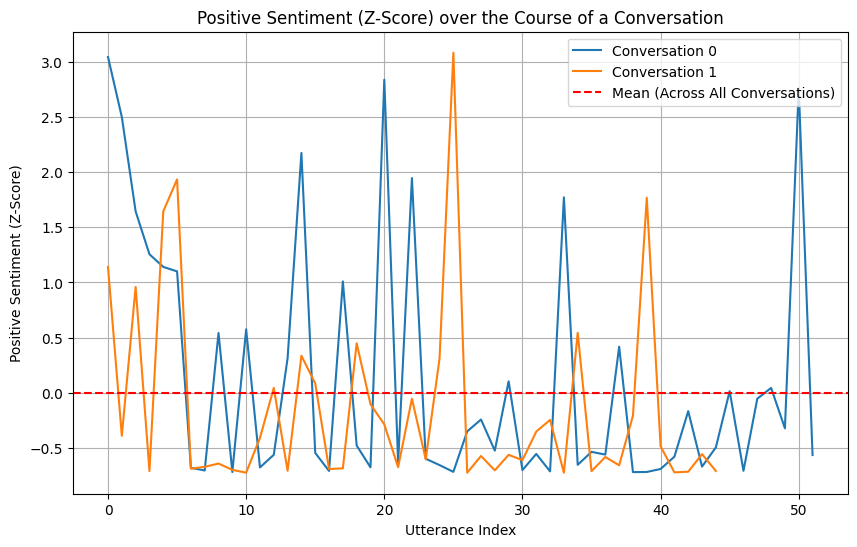

In [14]:
plot_feature_in_conversation(utterance_features, colname="positivity_zscore_chats", col_readable_name="Positive Sentiment (Z-Score)")

Here, we show the **number of characters** in each utterance over the course of the conversation. We see a rough U-shape --- messages start very short (e.g., "hi!") and end short (e.g., "bye!"), but are longer during the middle parts of a conversation, where the primary discussion takes place.

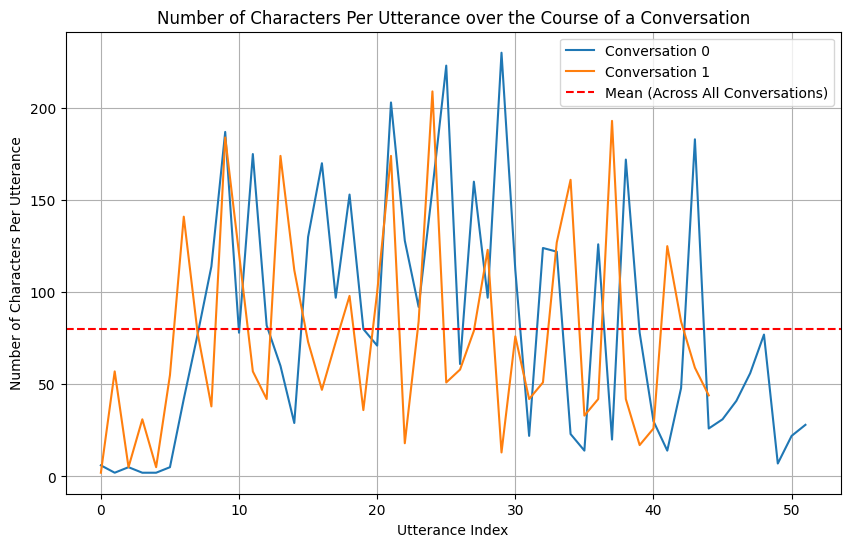

In [15]:
plot_feature_in_conversation(utterance_features, colname="num_chars", col_readable_name="Number of Characters Per Utterance")

Here, we plot the level of **Certainty** (https://conversational-featurizer.readthedocs.io/en/latest/features_conceptual/certainty.html) across the two conversations.

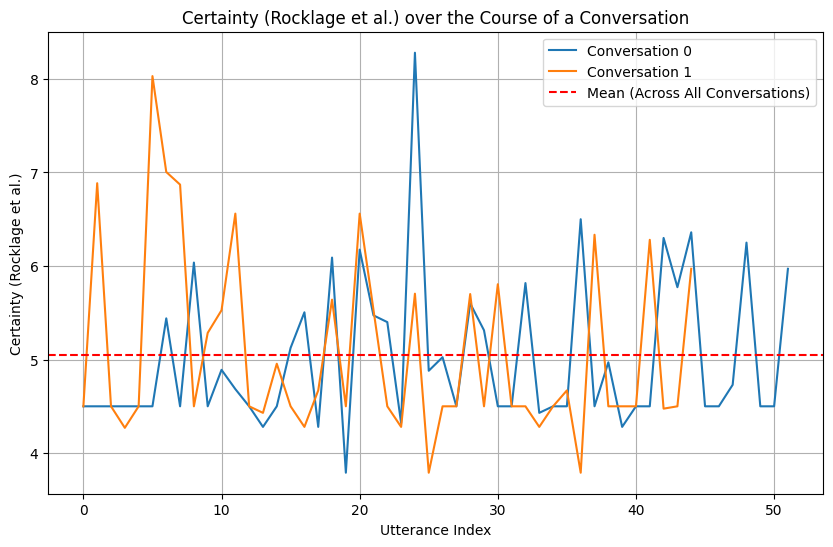

In [16]:
plot_feature_in_conversation(utterance_features, colname="certainty_rocklage", col_readable_name="Certainty (Rocklage et al.)")

We observe that, in the first conversation, speakers appear to make several high-certainty statements at the beginning of the conversation, before the level of certainty tapers off. We can inspect this a little further in the heatmap below --- and we observe that, in the opening few statements, participants begin by strongly stating their opinions ("I dont think shes an asshole...") but as the conversation opens up, there are fewer such strong-certainty statements.

Peeking into specific features in a manner like this might allow us to get more insight into what is actually "happening" in a conversation when we see a metric light up in a particular way.

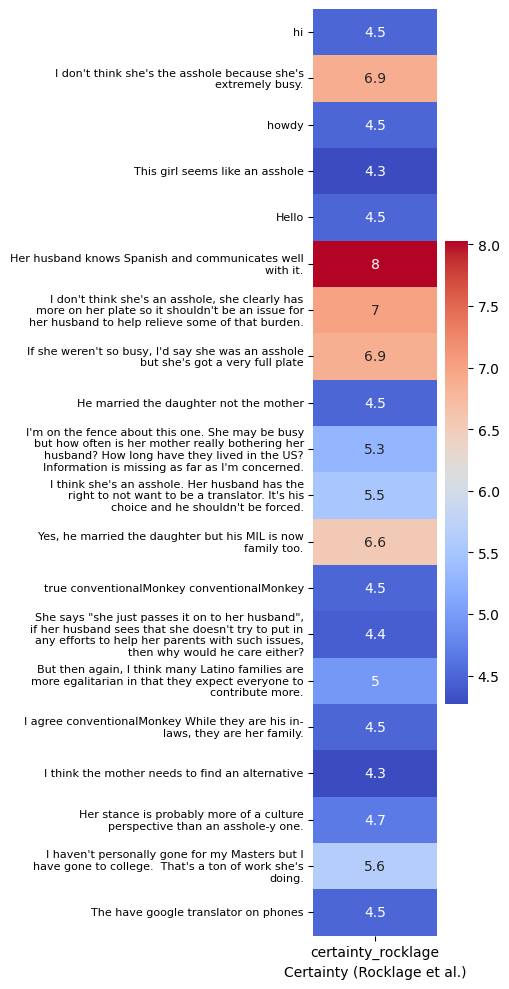

In [17]:
conversation_1_subset = utterance_features[utterance_features["conversation_num"] == 1].iloc[0:20]
# note that, once the data is processed, the original message will go into a column called "message_original", and the "message" column will be preprocessed to remove punctuation and turn everything to lowercase
conversation_1_subset[["speaker_nickname", "message_original", "certainty_rocklage"]]

# Plot a heatmap of a specific subset we want to look more into
heatmap_data = conversation_1_subset.reset_index(drop=True)[['certainty_rocklage']].T
conversation_1_subset = conversation_1_subset.reset_index(drop=True)
conversation_1_subset['wrapped_message'] = conversation_1_subset['message_original'].apply(lambda x: '\n'.join(textwrap.wrap(x, width=50)))
plt.figure(figsize=(5, len(conversation_1_subset) * 0.5))
ax = sns.heatmap(conversation_1_subset[['certainty_rocklage']], annot=True, cmap="coolwarm", cbar=True, yticklabels=conversation_1_subset['wrapped_message'])
plt.xlabel("Certainty (Rocklage et al.)")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

Another possible way of visualizing examines the distribution of different features across different conversations. For example, here, we draw density plots for a feature (Positivity Z-Score) between the two conversations, and we observe that Conversation 0 appears to be a bit more positive in general than Conversation 1.

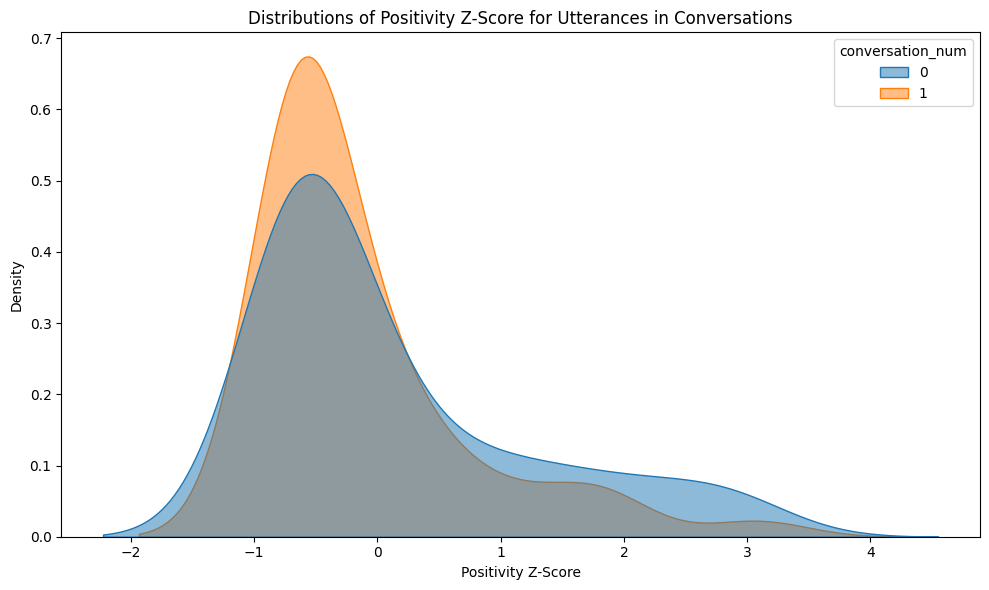

In [18]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=utterance_features, x='positivity_zscore_chats', hue='conversation_num', fill=True, common_norm=False, alpha=0.5)
human_label = 'Positivity Z-Score'
plt.title('Distributions of ' + human_label + ' for Utterances in Conversations')
plt.xlabel(human_label)
plt.ylabel('Density')
plt.tight_layout()
plt.show()

As you can hopefully see by now, there are lots of things you can do with the features --- the key is that the Team Communication Toolkit generates the features for you, and then the rest is your playground.

## Conversation Level

The second level of analysis we examine is that of the **entire conversation**. We can find information about the conversation level in its respective output file.

In [19]:
conversation_features = pd.read_csv("./output/conv/jury_tiny_output_conversation_level.csv")

Again, we have a variety of features that we can generate at this level! We can start by just describing the dataframe and scrolling through the features. What's helpful is that the `conversation_features` dataframe has just two rows --- one for each of the two conversations in our miniature dataset. This means that we can look into conversations in which there is a noticeable difference between the two rows, which suggests that there might be something interesting distinguishing the conversations.

In [20]:
# these are all the conversation features we generate, including aggregations
conversation_cols = jury_feature_builder.conv_features_all
conversation_features[conversation_cols]

,turn_taking_index,gini_coefficient_sum_num_words,gini_coefficient_sum_num_chars,gini_coefficient_sum_num_messages,team_burstiness,average_positive_bert,stdev_positive_bert,min_positive_bert,max_positive_bert,average_negative_bert,...,stdev_user_avg_forward_flow,min_user_avg_forward_flow,max_user_avg_forward_flow,info_diversity,discursive_diversity,variance_in_DD,incongruent_modulation,within_person_disc_range,message_original,message_lower_with_punc
0,0.980392,0.159463,0.166055,0.18750,0.037380,0.192184,0.242023,0.006599,0.837152,0.381502,...,0.052977,0.485594,0.645007,0.318921,0.406655,0.004126,0.060308,1.303592,Hello!,hello!
1,1.000000,0.125695,0.124663,0.27037,-0.166857,0.134533,0.188477,0.005377,0.845765,0.415384,...,0.070613,0.439604,0.610393,0.282060,0.362725,0.002987,0.024873,0.921299,hi,hi


In [21]:
# and these are the conversation features that are not aggregations
conversation_features[jury_feature_builder.conv_features_base]

,turn_taking_index,gini_coefficient_sum_num_words,gini_coefficient_sum_num_chars,gini_coefficient_sum_num_messages,team_burstiness,team_burstiness,info_diversity,discursive_diversity,variance_in_DD,incongruent_modulation,within_person_disc_range
0,0.980392,0.159463,0.166055,0.18750,0.037380,0.037380,0.318921,0.406655,0.004126,0.060308,1.303592
1,1.000000,0.125695,0.124663,0.27037,-0.166857,-0.166857,0.282060,0.362725,0.002987,0.024873,0.921299


One feature we observe is `team_burstiness` (https://conversational-featurizer.readthedocs.io/en/latest/features_conceptual/team_burstiness.html). Here, we observe that the first team (Conversation 0) appears substantially more "bursty" than the second (Conversation 1); its burstiness score is a small positive value, whereas the second team's burstiness score is a negative value.

In [22]:
conversation_features["team_burstiness"]

0    0.037380
1   -0.166857
Name: team_burstiness, dtype: float64

Can we plot the timings of utterances to explore whether this is the case? Here, we go back to the utterance-level data after observing a pattern at the conversation level...

In [23]:
# Get time elapsed for each message since start of the conversation
utterance_features['timestamp'] = pd.to_datetime(utterance_features['timestamp'])
utterance_features = utterance_features.sort_values(by=['conversation_num', 'timestamp'])
utterance_features['time_elapsed'] = utterance_features.groupby('conversation_num')['timestamp'].transform(lambda x: (x - x.min()).dt.total_seconds())

# Normalize time_elapsed counts by the total number of messages per conversation
counts_per_conversation = utterance_features['conversation_num'].value_counts()
utterance_features['normalized_count'] = utterance_features.groupby('conversation_num')['time_elapsed'].transform(lambda x: 1.0 / len(x))

As it turns out, **yes** -- we can see that Conversation 0 (in blue) is more "bursty," with very high peaks in which messages tend to come in very quick succession. Conversation 1 (in orange) is much more evenly spaced out in contrast --- every time period has bars that are roughly similar in height. This conversation is more period, and therefore less "bursty," overall.

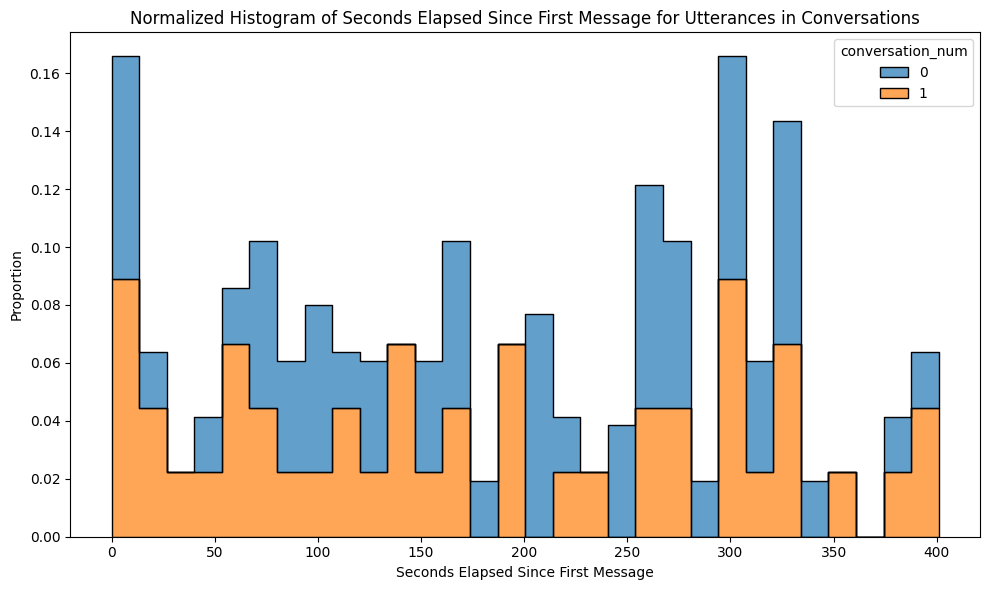

In [24]:
# Plot histogram of when messages are coming in
plt.figure(figsize=(10, 6))
sns.histplot(data=utterance_features, x='time_elapsed', hue='conversation_num', weights='normalized_count', multiple='stack', bins=30, element='step', alpha=0.7)
human_label = 'Seconds Elapsed Since First Message'
plt.title('Normalized Histogram of ' + human_label + ' for Utterances in Conversations')
plt.xlabel(human_label)
plt.ylabel('Proportion')
plt.tight_layout()
plt.show()

## Speaker (User) Level

The final level of analysis examines the specific individuals who participated in the conversation. Here, **each row of the dataframe represents a specific *individual* who appeared in our data.** We can then see attributes of the individual --- how many words did they speak, how positive or negative were they, and so on?

In [25]:
speaker_features = pd.read_csv("./output/user/jury_tiny_output_user_level.csv")
speaker_features

,conversation_num,speaker_nickname,average_positive_bert,average_negative_bert,average_neutral_bert,average_num_words,average_num_chars,average_num_messages,average_info_exchange_zscore_chats,average_info_exchange_zscore_conversation,...,sum_num_line_breaks,sum_num_quotes,sum_num_block_quote_responses,sum_num_ellipses,sum_num_parentheses,sum_num_emoji,sum_mimicry_bert,sum_moving_mimicry,sum_forward_flow,user_list
0,0,niceRhino,0.356771,0.084720,0.558509,15.875000,81.625000,1.0,-0.009064,-0.075015,...,8,0,0,0,2,0,1.731247,3.016273,4.953423,['culturedCow' 'spryBison' 'youngLion' 'smallG...
1,0,culturedCow,0.161326,0.495867,0.342807,28.000000,145.000000,1.0,0.991718,0.871433,...,5,2,0,0,0,0,1.823616,2.494478,2.539859,['niceRhino' 'spryBison' 'youngLion' 'smallGir...
2,0,spryBison,0.297614,0.312863,0.389523,9.777778,45.222222,1.0,-0.470982,-0.511854,...,9,0,0,0,0,0,2.924477,4.013453,5.303996,['niceRhino' 'culturedCow' 'youngLion' 'smallG...
3,0,youngLion,0.083168,0.558676,0.358156,15.875000,78.375000,1.0,0.012645,-0.054484,...,8,2,0,0,0,0,3.689977,3.647838,4.762858,['niceRhino' 'culturedCow' 'spryBison' 'smallG...
4,0,smallGiraffe,0.172383,0.423620,0.403998,11.375000,55.375000,1.0,-0.378116,-0.424030,...,8,1,0,0,0,0,2.305697,3.786036,4.647392,['niceRhino' 'culturedCow' 'spryBison' 'youngL...
5,0,culturedBear,0.144971,0.174196,0.680834,20.500000,99.666667,1.0,0.464914,0.373231,...,6,0,0,0,0,0,1.531364,2.634271,2.913562,['niceRhino' 'culturedCow' 'spryBison' 'youngL...
6,0,spryOrangutan,0.103209,0.648681,0.248110,18.571429,93.857143,1.0,0.274703,0.193346,...,7,1,0,0,0,0,1.961317,2.603867,4.515048,['niceRhino' 'culturedCow' 'spryBison' 'youngL...
7,0,littleSquirrel,0.017574,0.420926,0.561500,30.000000,183.000000,1.0,1.217491,1.084948,...,1,0,0,0,0,0,0.308643,0.327093,0.521758,['niceRhino' 'culturedCow' 'spryBison' 'youngL...
8,1,newLion,0.095934,0.386197,0.517869,6.333333,36.083333,1.0,-0.779731,-0.757137,...,12,1,0,0,0,0,2.755768,2.274712,7.213783,['likelyRabbit' 'conventionalMonkey' 'littleCo...
9,1,likelyRabbit,0.280653,0.293505,0.425842,11.000000,55.444444,1.0,-0.413091,-0.359744,...,9,4,0,0,0,0,2.443192,1.628115,5.493533,['newLion' 'conventionalMonkey' 'littleCow' 'n...


Let's look at the first feature (`average_negative_bert`), which measures the extent of "negativity" expressed by each speaker on average. As an exploration, let's rank the most and least negative speakers, and let's print out their messages.

### Here are the most negative 5 speakers

You can observe that many of these "negative" speakers happen, in this case, to be advocating for the perspective that the person in the prompt is the "asshole" (which is the objective of the r/AmITheAsshole). The fact that the word "asshole" is so strongly associated with negative sentiment may be one reason why these people end up being the "most negative speakers."

This observation definitely makes salient that what a feature means depends on the context; while calling someone an "asshole" might often been taken as an insult, here's it's a very specific perspective in a very specific setting.

In [26]:
more_negative_speakers = speaker_features.sort_values(by='average_negative_bert', ascending=False)[["conversation_num", "speaker_nickname", "average_negative_bert"]].head(5)
more_negative_speakers

,conversation_num,speaker_nickname,average_negative_bert
6,0,spryOrangutan,0.648681
3,0,youngLion,0.558676
11,1,littleCow,0.530565
10,1,conventionalMonkey,0.515654
1,0,culturedCow,0.495867


In [27]:
negative_person_messages = utterance_features[(utterance_features["speaker_nickname"].isin(more_negative_speakers["speaker_nickname"]))]["message_original"]

for message in negative_person_messages:
    print(message)

Hi!
Hi
I can see how the family is upset because they feel the mother was disrespected but I can also understand the guy's feelings. Why should he have to work as interpreter for his mother in law?
I was conflicted because I could understand his frustration however I feel he should have maybe discussed strategies with how to approach the mother in law with his wife first.
I don't think he's an asshole. I think his request is reasonable. If you go to live in a foreign country, you should learn the language.
I think the guy is an asshole because for all his talk about how easy it is to use resources to learn a language, he didn't take the time to research WHY some people do not.
I think also he needs to understand that language learning is not the same for everyone, not everyone has the same capacity to learn new languages quickly.
Maybe she does have a problem with learning languages, but she could at least try.
Learning a second language is easiest when you're a child for a reason. You

### Here are the least negative 5 speakers

Here, we observe that the least negative speakers generally tended to argue that the person in question was *not* the "asshole," which is the reverse of the pattern we saw when we looked at the most negative five speakers.

In [28]:
less_negative_speakers = speaker_features.sort_values(by='average_negative_bert', ascending=True)[["conversation_num", "speaker_nickname", "average_negative_bert"]].head(5)
less_negative_speakers

,conversation_num,speaker_nickname,average_negative_bert
0,0,niceRhino,0.084720
5,0,culturedBear,0.174196
9,1,likelyRabbit,0.293505
13,1,likelyGorilla,0.302361
2,0,spryBison,0.312863


In [29]:
less_negative_messages = utterance_features[(utterance_features["speaker_nickname"].isin(less_negative_speakers["speaker_nickname"]))]["message_original"]

for message in less_negative_messages:
    print(message)

Hello! 
Hello
hello
So who thinks the guy is an ass for asking his mother in law to learn english
I think that this person is not an asshole because, according to him, he was very polite while approaching the issue
Yes, I think his feeling makes sense to me to. Who doesn't want to be independent.
I think he had every right to want to help his mother in law
I also agree with culturedCow
I think he also tried to utilize other resources such as language learning apps to help her learn
After the edit he done it made it sound like he really loves his family
I don't think the guy is wrong in asking her to learn more english being that she lives in America, but he has to understand she is older and may not have the patience or capacity to learn a lot of english.
He should also ask his wife to step up and talk to the mother to healp her learn more and to make herself more available to her mother to help with translations.
I think that both sides have right and wrong. But overall i think he's n